In [305]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
# data plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("data/combined_expression.csv")
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,1,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,0,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,0,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,0,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,0,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [4]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [306]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if cbar:
        plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 5-Fold Validation for 5 Hidden Layers

In [6]:
def hidden5(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model5 = KerasClassifier(build_fn=hidden5, epochs=50, batch_size=16, optimizer='adagrad',init='normal')
kf = KFold(n_splits=5)

cm_results = []
history_results = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    # fitting
    history = model5.fit(X_train, y_train, validation_data=(X_test,y_test))
    # recording
    cm_results.append(confusion_matrix(y_test, model5.predict(X_test)))
    history_results.append(history)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 4s 9ms/sample - loss: 0.6198 - accuracy: 0.7593 - val_loss: 0.4398 - val_accuracy: 0.9266
Epoch 2/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4226 - accuracy: 0.8241 - val_loss: 0.4251 - val_accuracy: 0.8991
Epoch 3/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4957 - accuracy: 0.8102 - val_loss: 0.3776 - val_accuracy: 0.9174
Epoch 4/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4827 - accuracy: 0.7963 - val_loss: 0.4792 - val_accuracy: 0.7798
Epoch 5/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4823 - accuracy: 0.7940 - val_loss: 0.4075 - val_accuracy: 0.8991
Epoch 6/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4423 - accuracy: 0.8218 - val_loss: 0.3233 - val_accuracy: 0.9358
Epoch 7/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4255 - accur

Epoch 7/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3944 - accuracy: 0.8499 - val_loss: 0.4420 - val_accuracy: 0.8704
Epoch 8/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3598 - accuracy: 0.8614 - val_loss: 0.4383 - val_accuracy: 0.8704
Epoch 9/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2950 - accuracy: 0.8915 - val_loss: 0.4416 - val_accuracy: 0.8704
Epoch 10/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3253 - accuracy: 0.8868 - val_loss: 0.4686 - val_accuracy: 0.8704
Epoch 11/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3208 - accuracy: 0.8845 - val_loss: 0.4673 - val_accuracy: 0.8796
Epoch 12/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3010 - accuracy: 0.8891 - val_loss: 0.4562 - val_accuracy: 0.8796
Epoch 13/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3199 - accuracy: 0.8845 - val_loss: 0.4529 - val_accur

433/433 [==============================] - 1s 3ms/sample - loss: 0.3471 - accuracy: 0.8637 - val_loss: 0.4934 - val_accuracy: 0.8426
Epoch 14/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2988 - accuracy: 0.8961 - val_loss: 0.5108 - val_accuracy: 0.8333
Epoch 15/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2897 - accuracy: 0.8776 - val_loss: 0.5360 - val_accuracy: 0.8426
Epoch 16/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2667 - accuracy: 0.8661 - val_loss: 0.5351 - val_accuracy: 0.8519
Epoch 17/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2812 - accuracy: 0.9030 - val_loss: 0.5342 - val_accuracy: 0.8519
Epoch 18/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3099 - accuracy: 0.8799 - val_loss: 0.5613 - val_accuracy: 0.8426
Epoch 19/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2514 - accuracy: 0.9122 - val_loss: 0.5826 - val_accuracy: 0.83

433/433 [==============================] - 1s 3ms/sample - loss: 0.3122 - accuracy: 0.8753 - val_loss: 0.5800 - val_accuracy: 0.8241
Epoch 20/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3141 - accuracy: 0.8637 - val_loss: 0.5905 - val_accuracy: 0.8148
Epoch 21/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2941 - accuracy: 0.8753 - val_loss: 0.6202 - val_accuracy: 0.8056
Epoch 22/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2997 - accuracy: 0.8730 - val_loss: 0.6125 - val_accuracy: 0.8148
Epoch 23/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3016 - accuracy: 0.8868 - val_loss: 0.6236 - val_accuracy: 0.8241
Epoch 24/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3424 - accuracy: 0.8661 - val_loss: 0.6494 - val_accuracy: 0.8241
Epoch 25/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2903 - accuracy: 0.8799 - val_loss: 0.6635 - val_accuracy: 0.81

433/433 [==============================] - 1s 3ms/sample - loss: 0.3232 - accuracy: 0.8730 - val_loss: 0.4161 - val_accuracy: 0.8148
Epoch 26/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2690 - accuracy: 0.9053 - val_loss: 0.4070 - val_accuracy: 0.8148
Epoch 27/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2869 - accuracy: 0.9030 - val_loss: 0.4094 - val_accuracy: 0.8241
Epoch 28/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2945 - accuracy: 0.8753 - val_loss: 0.4101 - val_accuracy: 0.8148
Epoch 29/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2988 - accuracy: 0.8730 - val_loss: 0.4149 - val_accuracy: 0.8056
Epoch 30/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2805 - accuracy: 0.8891 - val_loss: 0.4059 - val_accuracy: 0.8056
Epoch 31/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2589 - accuracy: 0.8891 - val_loss: 0.4187 - val_accuracy: 0.80

In [79]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results:
    for j in cm_results[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

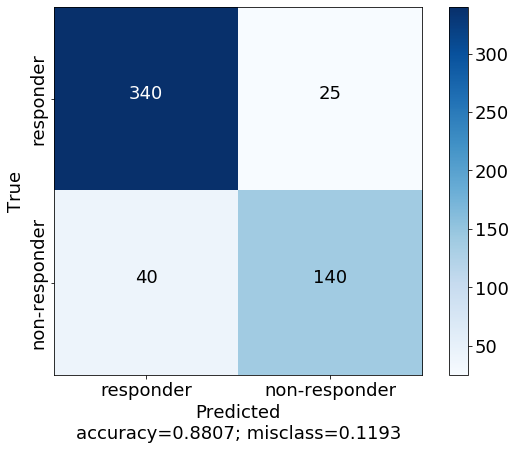

In [219]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='', normalize=False)

# 4 Hidden Layers

In [222]:
def hidden4(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [225]:
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
kf = KFold(n_splits=5)

cm_results4 = []
history_results4 = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    # fitting
    history4 = model4.fit(X_train, y_train, validation_data=(X_test,y_test))
    # recording
    cm_results4.append(confusion_matrix(y_test, model4.predict(X_test)))
    history_results4.append(history)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 3s 8ms/sample - loss: 0.5999 - accuracy: 0.7569 - val_loss: 1.0864 - val_accuracy: 0.3303
Epoch 2/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3917 - accuracy: 0.8565 - val_loss: 1.1699 - val_accuracy: 0.3303
Epoch 3/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.4168 - accuracy: 0.8495 - val_loss: 0.6589 - val_accuracy: 0.5688
Epoch 4/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3601 - accuracy: 0.8472 - val_loss: 0.4154 - val_accuracy: 0.8257
Epoch 5/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3565 - accuracy: 0.8681 - val_loss: 0.5732 - val_accuracy: 0.6881
Epoch 6/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3139 - accuracy: 0.8843 - val_loss: 0.4268 - val_accuracy: 0.7890
Epoch 7/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.2624 - accur

Epoch 7/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2388 - accuracy: 0.9238 - val_loss: 0.4353 - val_accuracy: 0.8519
Epoch 8/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2295 - accuracy: 0.9192 - val_loss: 0.4396 - val_accuracy: 0.8519
Epoch 9/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1803 - accuracy: 0.9192 - val_loss: 0.4756 - val_accuracy: 0.8148
Epoch 10/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1708 - accuracy: 0.9376 - val_loss: 0.4535 - val_accuracy: 0.8519
Epoch 11/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2115 - accuracy: 0.9099 - val_loss: 0.5360 - val_accuracy: 0.7315
Epoch 12/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2458 - accuracy: 0.9053 - val_loss: 0.5422 - val_accuracy: 0.7593
Epoch 13/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1845 - accuracy: 0.9330 - val_loss: 0.4988 - val_accur

433/433 [==============================] - 1s 2ms/sample - loss: 0.1227 - accuracy: 0.9584 - val_loss: 0.5844 - val_accuracy: 0.8426
Epoch 14/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1998 - accuracy: 0.9307 - val_loss: 0.6405 - val_accuracy: 0.7500
Epoch 15/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1672 - accuracy: 0.9492 - val_loss: 0.6550 - val_accuracy: 0.7870
Epoch 16/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1664 - accuracy: 0.9423 - val_loss: 0.6878 - val_accuracy: 0.7315
Epoch 17/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1541 - accuracy: 0.9400 - val_loss: 0.6445 - val_accuracy: 0.7500
Epoch 18/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1199 - accuracy: 0.9654 - val_loss: 0.6219 - val_accuracy: 0.7778
Epoch 19/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1455 - accuracy: 0.9446 - val_loss: 0.6084 - val_accuracy: 0.78

433/433 [==============================] - 1s 2ms/sample - loss: 0.1473 - accuracy: 0.9515 - val_loss: 0.5069 - val_accuracy: 0.8333
Epoch 20/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1665 - accuracy: 0.9492 - val_loss: 0.5345 - val_accuracy: 0.8426
Epoch 21/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1921 - accuracy: 0.9353 - val_loss: 0.5546 - val_accuracy: 0.8426
Epoch 22/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1652 - accuracy: 0.9423 - val_loss: 0.5091 - val_accuracy: 0.8426
Epoch 23/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1094 - accuracy: 0.9677 - val_loss: 0.5231 - val_accuracy: 0.8611
Epoch 24/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1538 - accuracy: 0.9400 - val_loss: 0.5313 - val_accuracy: 0.8241
Epoch 25/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1538 - accuracy: 0.9469 - val_loss: 0.5868 - val_accuracy: 0.83

433/433 [==============================] - 1s 2ms/sample - loss: 0.1235 - accuracy: 0.9561 - val_loss: 0.4599 - val_accuracy: 0.8241
Epoch 26/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1608 - accuracy: 0.9469 - val_loss: 0.4463 - val_accuracy: 0.8241
Epoch 27/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1652 - accuracy: 0.9353 - val_loss: 0.4627 - val_accuracy: 0.8148
Epoch 28/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1200 - accuracy: 0.9515 - val_loss: 0.4603 - val_accuracy: 0.8148
Epoch 29/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1332 - accuracy: 0.9423 - val_loss: 0.4679 - val_accuracy: 0.8056
Epoch 30/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1487 - accuracy: 0.9538 - val_loss: 0.4476 - val_accuracy: 0.8241
Epoch 31/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1017 - accuracy: 0.9538 - val_loss: 0.4459 - val_accuracy: 0.84

In [293]:
cm4 = [[0, 0]]
k, l = 0, 0
for i in cm_results4:
    for j in cm_results4[0]:
        cm4[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm4 = np.array(cm4[0])

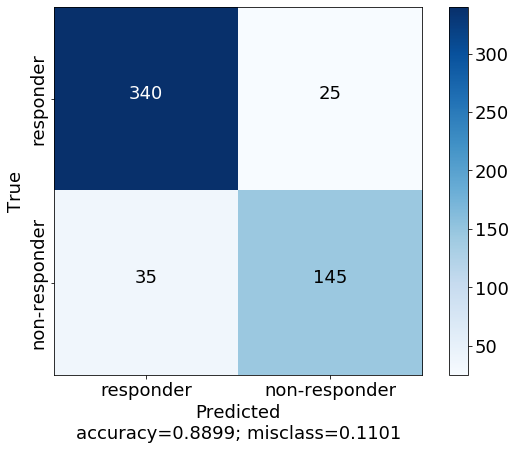

In [227]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm4, ['responder', 'non-responder'], title='', normalize=False)

# 3 Hidden Layers

In [251]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [296]:
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
kf = KFold(n_splits=5)

cm_results3 = []
history_results3 = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    # fitting
    history3 = model3.fit(X_train, y_train, validation_data=(X_test,y_test))
    # recording
    cm_results3.append(confusion_matrix(y_test, model3.predict(X_test)))
    history_results3.append(history)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 3s 6ms/sample - loss: 0.5903 - accuracy: 0.8102 - val_loss: 1.3038 - val_accuracy: 0.3303
Epoch 2/50
432/432 [==============================] - 0s 826us/sample - loss: 0.4130 - accuracy: 0.8634 - val_loss: 1.3841 - val_accuracy: 0.3303
Epoch 3/50
432/432 [==============================] - 0s 842us/sample - loss: 0.3564 - accuracy: 0.8634 - val_loss: 0.8878 - val_accuracy: 0.4404
Epoch 4/50
432/432 [==============================] - 0s 839us/sample - loss: 0.3475 - accuracy: 0.8704 - val_loss: 0.5882 - val_accuracy: 0.6147
Epoch 5/50
432/432 [==============================] - 0s 844us/sample - loss: 0.2833 - accuracy: 0.8843 - val_loss: 0.8651 - val_accuracy: 0.4128
Epoch 6/50
432/432 [==============================] - 0s 869us/sample - loss: 0.2699 - accuracy: 0.8912 - val_loss: 0.6625 - val_accuracy: 0.5596
Epoch 7/50
432/432 [==============================] - 0s 848us/sample - loss: 0.

433/433 [==============================] - 0s 976us/sample - loss: 0.2592 - accuracy: 0.9030 - val_loss: 0.5439 - val_accuracy: 0.7685
Epoch 7/50
433/433 [==============================] - 0s 977us/sample - loss: 0.2044 - accuracy: 0.9307 - val_loss: 0.7482 - val_accuracy: 0.6481
Epoch 8/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1877 - accuracy: 0.9192 - val_loss: 0.6663 - val_accuracy: 0.6852
Epoch 9/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.2285 - accuracy: 0.9099 - val_loss: 0.8826 - val_accuracy: 0.5556
Epoch 10/50
433/433 [==============================] - 0s 990us/sample - loss: 0.1780 - accuracy: 0.9376 - val_loss: 0.7643 - val_accuracy: 0.6481
Epoch 11/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.2018 - accuracy: 0.9307 - val_loss: 0.7386 - val_accuracy: 0.6296
Epoch 12/50
433/433 [==============================] - 0s 966us/sample - loss: 0.1629 - accuracy: 0.9376 - val_loss: 0.6298 - val_accuracy:

433/433 [==============================] - 0s 1ms/sample - loss: 0.1756 - accuracy: 0.9307 - val_loss: 0.6069 - val_accuracy: 0.7130
Epoch 13/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1595 - accuracy: 0.9330 - val_loss: 0.5709 - val_accuracy: 0.7222
Epoch 14/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1742 - accuracy: 0.9446 - val_loss: 0.7920 - val_accuracy: 0.6574
Epoch 15/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.2075 - accuracy: 0.9169 - val_loss: 0.6475 - val_accuracy: 0.7130
Epoch 16/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1435 - accuracy: 0.9423 - val_loss: 0.7096 - val_accuracy: 0.6944
Epoch 17/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1269 - accuracy: 0.9584 - val_loss: 0.8607 - val_accuracy: 0.6481
Epoch 18/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1456 - accuracy: 0.9515 - val_loss: 0.8125 - val_accuracy: 0.63

433/433 [==============================] - 0s 1ms/sample - loss: 0.1395 - accuracy: 0.9515 - val_loss: 0.6903 - val_accuracy: 0.8148
Epoch 19/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1736 - accuracy: 0.9353 - val_loss: 0.7576 - val_accuracy: 0.7778
Epoch 20/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1906 - accuracy: 0.9261 - val_loss: 0.6336 - val_accuracy: 0.8333
Epoch 21/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1445 - accuracy: 0.9561 - val_loss: 0.6718 - val_accuracy: 0.8241
Epoch 22/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1575 - accuracy: 0.9446 - val_loss: 0.7984 - val_accuracy: 0.7778
Epoch 23/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1488 - accuracy: 0.9515 - val_loss: 0.7278 - val_accuracy: 0.7963
Epoch 24/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1181 - accuracy: 0.9607 - val_loss: 0.6770 - val_accuracy: 0.81

433/433 [==============================] - 0s 1ms/sample - loss: 0.1194 - accuracy: 0.9607 - val_loss: 0.5274 - val_accuracy: 0.7685
Epoch 25/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1243 - accuracy: 0.9607 - val_loss: 0.5098 - val_accuracy: 0.7778
Epoch 26/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.0884 - accuracy: 0.9723 - val_loss: 0.5465 - val_accuracy: 0.7500
Epoch 27/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1123 - accuracy: 0.9654 - val_loss: 0.4898 - val_accuracy: 0.8148
Epoch 28/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1352 - accuracy: 0.9423 - val_loss: 0.5978 - val_accuracy: 0.7500
Epoch 29/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.0979 - accuracy: 0.9700 - val_loss: 0.4980 - val_accuracy: 0.7870
Epoch 30/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1210 - accuracy: 0.9515 - val_loss: 0.5739 - val_accuracy: 0.77

In [299]:
cm3 = [[0, 0]]
k, l = 0, 0
for i in cm_results3:
    for j in cm_results3[0]:
        cm3[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm3 = np.array(cm3[0])
cm3

array([[330,  35],
       [ 20, 160]])

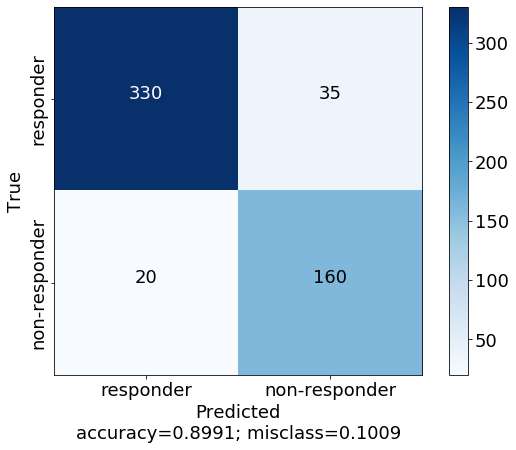

In [300]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm3, ['responder', 'non-responder'], title='', normalize=False)

# Comparison Plots

In [ ]:
loss, accuracy, val_loss, val_accuracy